# Modello di Poisson (2) {#sec-stan-poisson-model-2}

**Prerequisiti**

- Leggi [Racial Disparities in Police Use of Deadly Force Against Unarmed Individuals Persist After Appropriately Benchmarking Shooting Data on Violent Crime Rates](https://journals.sagepub.com/doi/full/10.1177/1948550620916071) per ottenere una panoramica approfondita su questo fenomeno e sul relativo ambito di ricerca.

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [1]:
import logging
import os
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import scipy.stats as stats

In [2]:
seed: int = sum(map(ord, "stan_poisson_model"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(
    home_directory, '_repositories', 'psicometria')

## Introduction {.unnumbered}

Nel capitolo precedente abbiamo esaminato il processo di derivazione della distribuzione a posteriori per i parametri della distribuzione Gamma, la quale viene impiegata quando si adotta un prior Gamma per una verosimiglianza di Poisson. In questo capitolo, useremo tale metodo per affrontare una questione relativa all'analisi di un set di dati reali.

## Domanda della ricerca

Come spiegato [qui](https://github.com/washingtonpost/data-police-shootings), i dati che esamineremo sono raccolti dal Washington Post con lo scopo di registrare ogni sparatoria mortale negli Stati Uniti ad opera di agenti di polizia, a partire dal 1° gennaio 2015. Il Washington Post ha adottato un approccio sistematico e accurato nella raccolta di queste informazioni, fornendo dati che possono essere utili per valutare i problemi legati alla violenza delle forze di polizia negli Stati Uniti.

Lo scopo della presente analisi dei dati è determinare il tasso di sparatorie fatali da parte della polizia negli Stati Uniti per ogni anno, e fornire una stima dell'incertezza associata a questo valore.

## Importazione e pre-processing dei dati

In [3]:
url = "https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/v2/fatal-police-shootings-data.csv"
fps_dat = pd.read_csv(url)
fps_dat.head()

,id,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
0,3,2015-01-02,point,not,gun,Shelton,Mason,WA,47.246826,-123.121592,not_available,Tim Elliot,53.0,male,A,not_available,True,False,73
1,4,2015-01-02,point,not,gun,Aloha,Washington,OR,45.487421,-122.891696,not_available,Lewis Lee Lembke,47.0,male,W,not_available,False,False,70
2,5,2015-01-03,move,not,unarmed,Wichita,Sedgwick,KS,37.694766,-97.280554,not_available,John Paul Quintero,23.0,male,H,not_available,False,False,238
3,8,2015-01-04,point,not,replica,San Francisco,San Francisco,CA,37.762910,-122.422001,not_available,Matthew Hoffman,32.0,male,W,not_available,True,False,196
4,9,2015-01-04,point,not,other,Evans,Weld,CO,40.383937,-104.692261,not_available,Michael Rodriguez,39.0,male,H,not_available,False,False,473


In [4]:
# Convert date
fps_dat["date"] = pd.to_datetime(fps_dat["date"])

# Create a new column 'year' to store the year information from the 'date' column
fps_dat["year"] = fps_dat["date"].dt.year

fps_dat.columns

Index(['id', 'date', 'threat_type', 'flee_status', 'armed_with', 'city',
       'county', 'state', 'latitude', 'longitude', 'location_precision',
       'name', 'age', 'gender', 'race', 'race_source',
       'was_mental_illness_related', 'body_camera', 'agency_ids', 'year'],
      dtype='object')

In [5]:
# Filter out rows with year equal to 2024
fps = fps_dat[fps_dat["year"] != 2024]

# Count occurrences of each year in fps
year_counts = fps["year"].value_counts()
print(year_counts)

year
2023    1164
2022    1095
2021    1050
2020    1020
2015     995
2019     994
2018     991
2017     984
2016     959
Name: count, dtype: int64


Creiamo un DataFrame con i dati necessari per PyMC.

In [6]:
year_counts.values

array([1164, 1095, 1050, 1020,  995,  994,  991,  984,  959])

In [7]:
# Convert year_counts Series to a DataFrame
df = year_counts.reset_index()  # This converts the index (year) to a column and resets the index of the DataFrame
df.columns = ['year', 'events']  # Renaming the columns to 'year' and 'events'

# Now, df is the DataFrame you wanted, with 'year' and 'events' columns
print(df)

   year  events
0  2023    1164
1  2022    1095
2  2021    1050
3  2020    1020
4  2015     995
5  2019     994
6  2018     991
7  2017     984
8  2016     959


## Modello di Poisson

Il nostro interesse riguarda il tasso di occorrenza di sparatorie fatali da parte della polizia per anno. Indicheremo questo tasso come $\theta$, e il suo intervallo di valori possibili è $[0, \infty)$. Un modello di Poisson rappresenta tipicamente il punto di partenza per l'analisi di dati relativi alle frequenze assolute di un evento in un intervallo di tempo fissato. Il modello presuppone che i dati seguano una distribuzione di Poisson con un parametro di tasso $\lambda$:

$$
P(Y = y \mid \lambda) = \frac{\lambda^y \cdot e^{-\lambda}}{y!}, \quad \text{per} \quad y = 0, 1, 2, \ldots
$$

## Distribuzione a priori

Come distribuzione a priori per il parametro $\lambda$ nel modello di Poisson possiamo usare la distribuzione Gamma, poiché è una scelta coniugata. Ciò significa che, quando viene combinata con la distribuzione di Poisson come verosimiglianza dei dati, la distribuzione Gamma produce una distribuzione a posteriori con una forma analitica semplice. Questa caratteristica semplifica il processo di inferenza bayesiana.

Nel nostro caso, il parametro $\lambda$ rappresenta il tasso di occorrenza di sparatorie fatali per anno negli Stati Uniti. Prima di osservare i dati effettivi riportati dal Washington Post, abbiamo una conoscenza limitata su tale fenomeno. Pertanto, dobbiamo specificare una distribuzione a priori per $\lambda$ che rifletta la nostra incertezza iniziale. As esempio, possiamo ipotizzare che ci sia, in media, una sparatoria mortale per stato al mese, quindi 12 sparatorie mortali all'anno per stato. Questo ci porta a una stima iniziale di 600 sparatorie fatali negli Stati Uniti ogni anno. Dato che non siamo molto sicuri di questa ipotesi, vogliamo specificare una distribuzione a priori con un certo grado di incertezza. Imponiamo dunque una deviazione standard pari a 200.

Per visualizzare la distribuzione a priori per il parametro $\lambda$, creiamo un istogramma della distribuzione Gamma con i parametri specificati usando PyMC.

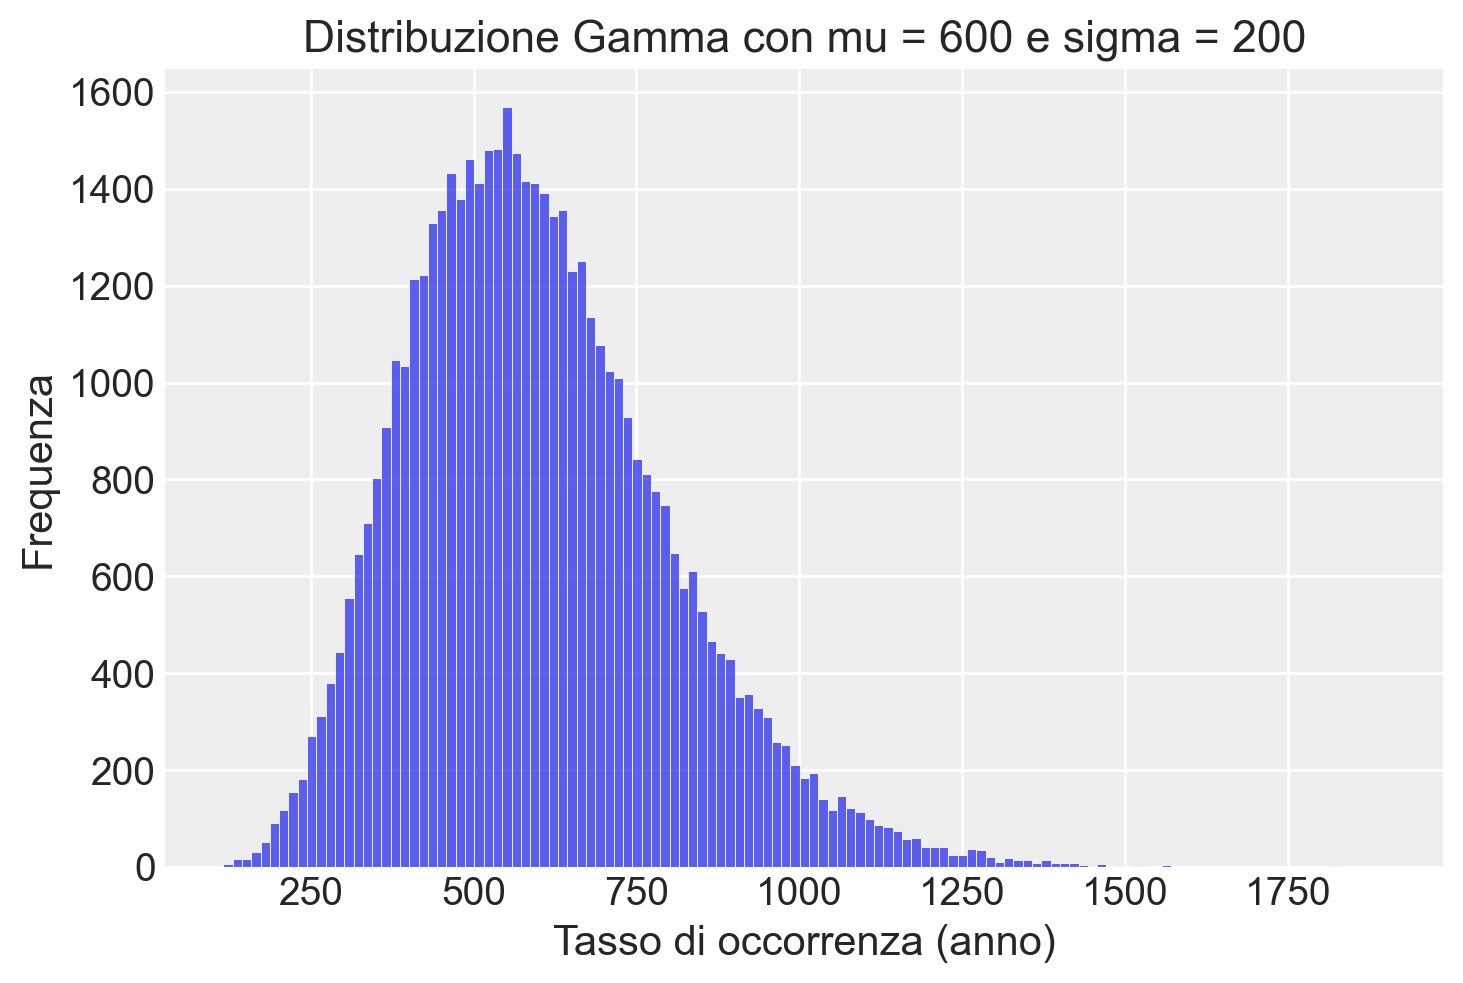

In [8]:
# Parameters for the Gamma distribution
mu = 600
sigma = 200

# Convert mu and sigma to shape (k) and scale (theta) parameters
theta = sigma**2 / mu
k = mu / theta

# Draw samples from the Gamma distribution
x_draws = stats.gamma.rvs(a=k, scale=theta, size=50000, random_state=2)

# Plot the histogram of the drawn samples
sns.histplot(x_draws, kde=False)

# Add labels and title
plt.xlabel("Tasso di occorrenza (anno)")
plt.ylabel("Frequenza")
plt.title("Distribuzione Gamma con mu = 600 e sigma = 200")
plt.show()

## Modello di Poisson con Stan

Formuliamo il modello di Poisson usando questi iper-parametri per la distribuzione a priori del parametro $\lambda$ (`rate`) della distribuzione di Poisson.

In [9]:
stan_file = os.path.join(project_directory, "stan", "poisson_model2.stan")
model = CmdStanModel(stan_file=stan_file)

In [10]:
print(model.code())

data {
  int<lower=0> N; // numero di osservazioni
  real<lower=0> mu; // parametro mu per la distribuzione Gamma
  real<lower=0> sigma; // parametro sigma per la distribuzione Gamma
  array[N] int<lower=0> y; // dati osservati  
}
parameters {
  real<lower=0> rate; // parametro rate per la distribuzione Poisson
}
model {
  // Priori
  rate ~ gamma(mu ^ 2 / sigma ^ 2, mu / sigma ^ 2);
  
  // Likelihood
  y ~ poisson(rate);
}



In [12]:
# Caricare i dati
stan_data = {
    "y": [1164, 1095, 1050, 1020, 995, 994, 991, 984, 959],
    "N": 9,
    "mu": 600,
    "sigma": 200
}
print(stan_data)

{'y': [1164, 1095, 1050, 1020, 995, 994, 991, 984, 959], 'N': 9, 'mu': 600, 'sigma': 200}


In [13]:
trace = model.sample(
    data=stan_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo la distribuzione a posteriori del parametro `rate`.

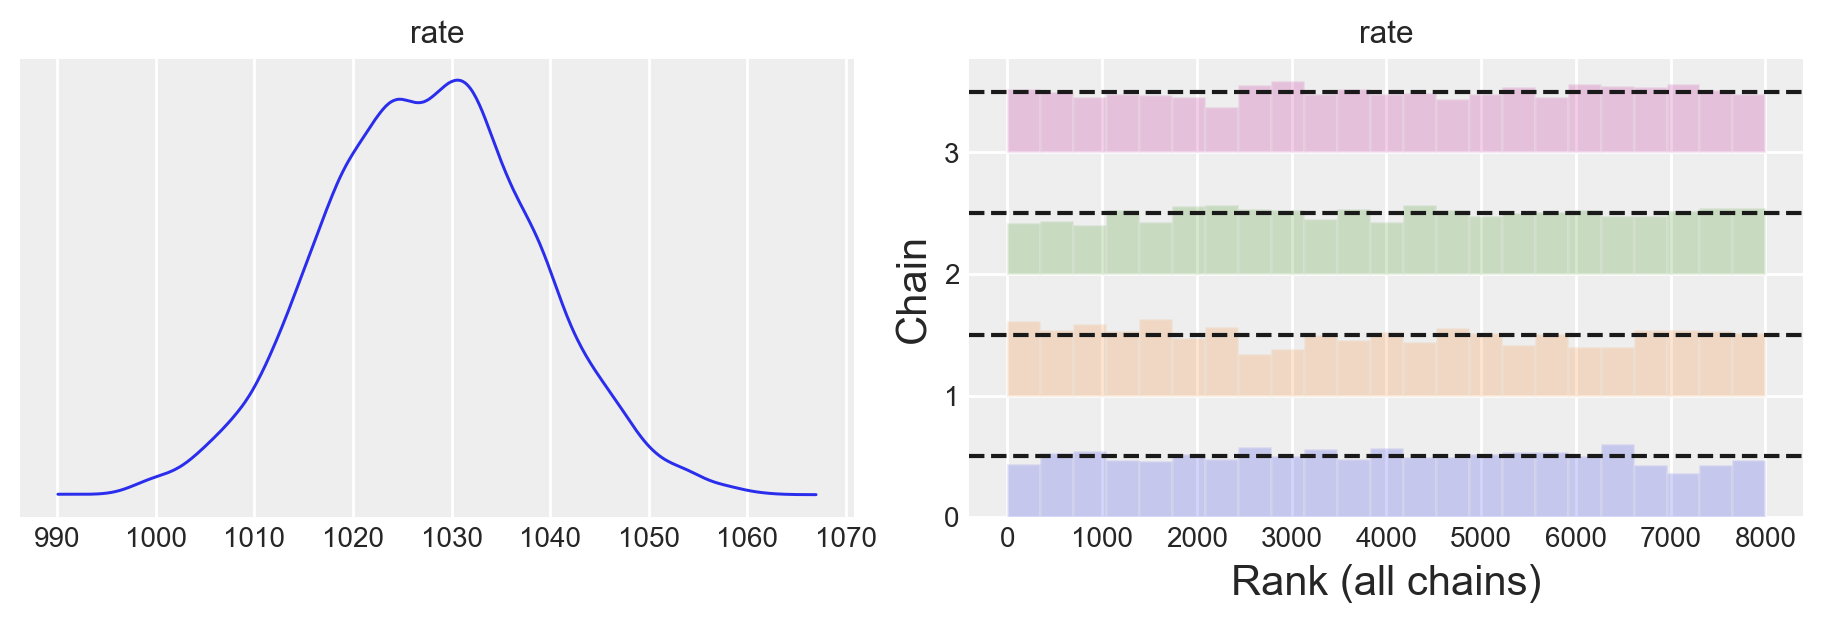

In [14]:
az.plot_trace(trace, combined=True, kind="rank_bars", figsize=(9, 3))
plt.show()

Il modello converge rapidamente e i grafici delle tracce sembrano ben mescolati. 

Generiamo un sommario numerico della distribuzione a posteriori.

In [15]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rate,1027.577,10.825,1007.56,1048.1,0.207,0.146,2737.0,3896.0,1.0


In [16]:
print(model.code())

data {
  int<lower=0> N; // numero di osservazioni
  real<lower=0> mu; // parametro mu per la distribuzione Gamma
  real<lower=0> sigma; // parametro sigma per la distribuzione Gamma
  array[N] int<lower=0> y; // dati osservati  
}
parameters {
  real<lower=0> rate; // parametro rate per la distribuzione Poisson
}
model {
  // Priori
  rate ~ gamma(mu ^ 2 / sigma ^ 2, mu / sigma ^ 2);
  
  // Likelihood
  y ~ poisson(rate);
}



Usiamo ArviZ per generare l'intervallo di credibilità al 94% per la distribuzione a posteriori del parametro `rate`.

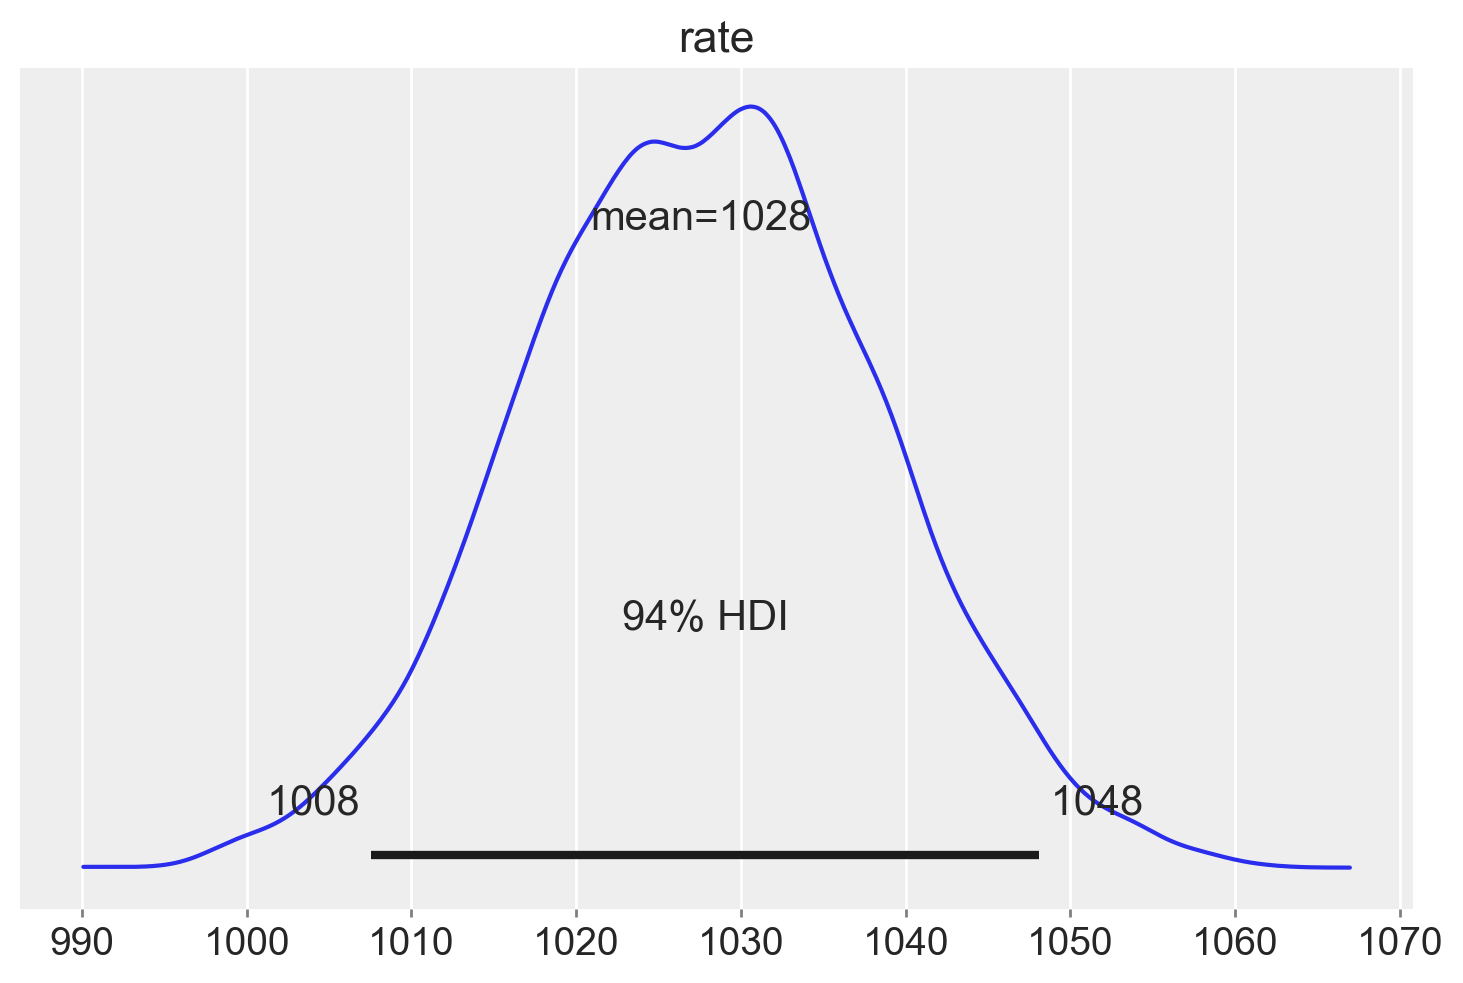

In [17]:
az.plot_posterior(trace, var_names="rate")
plt.show()

In sintesi, analizzando i dati compresi tra il 2015 e il 2023 e basandoci su una distribuzione a priori che presuppone una sparatoria mortale al mese per stato, possiamo concludere con un grado di certezza soggettivo del 94% che il tasso stimato di sparatorie fatali da parte della polizia negli Stati Uniti sia di 1028 casi all'anno, con un intervallo di credibilità compreso tra 1008 e 1048.

## Derivazione analitica

Per derivare i parametri della distribuzione Gamma ($\alpha$ e $\beta$) conoscendo la media ($\mu$) e la deviazione standard ($\sigma$), possiamo utilizzare le seguenti relazioni:

1. $\alpha = (\frac{\mu}{\sigma})^2$
2. $\beta = \frac{\mu}{\sigma^2}$

Queste formule si basano sul fatto che la media della distribuzione Gamma è data da $\frac{\alpha}{\beta}$, mentre la varianza è $\frac{\alpha}{\beta^2}$. Inoltre, la deviazione standard è la radice quadrata della varianza.

La distribuzione a posteriori per $\lambda$, data una verosimiglianza di Poisson e una distribuzione a priori gamma, è ancora una distribuzione gamma con parametri aggiornati. Possiamo calcolare i parametri della distribuzione a posteriori nel modo seguente:

- Parametro di forma a posteriori (α_post) = α_prior + Σ(y_i), dove Σ(y_i) rappresenta la somma dei dati osservati.
- Parametro di tasso a posteriori (β_post) = β_prior + n, dove n è il numero di punti dati.

Con questi parametri aggiornati, possiamo poi calcolare la media a posteriori della distribuzione gamma e l'intervallo di credibilità. 

In [18]:
data = df["events"]

# Prior hyperparameters
alpha_prior = (mu / sigma)**2
beta_prior = mu / sigma**2

# Data summary
n = len(df["events"])
sum_y = np.sum(df["events"])

# Posterior hyperparameters
alpha_post = alpha_prior + sum_y
beta_post = beta_prior + n

# Posterior distribution (Gamma)
posterior_gamma = stats.gamma(alpha_post, scale=1 / beta_post)

# Calculate the mean and credibility interval (94%)
posterior_mean = posterior_gamma.mean()
credible_interval = posterior_gamma.interval(0.94)

print("Estimated Rate (Posterior Mean):", posterior_mean)
print("Credibility Interval (94%):", credible_interval)

Estimated Rate (Posterior Mean): 1027.287853577371
Credibility Interval (94%): (1007.3046264976574, 1047.4587209661117)


L'output delle istruzioni precedenti fornisce il tasso stimato a posteriori e l'intervallo di credibilità al 94%. A causa di approssimazioni numeriche, i valori non coincidono esattamente con i risultati ottenuti con PyMC, ma sono molto simili.

## Vittime non armate

Consideriamo ora uno studio di @ross2021racial. Nell'introduzione allo studio, gli autori affermano che studi precedenti hanno dimostrato che la polizia negli Stati Uniti uccide cittadini neri rispetto a cittadini bianchi a tassi più elevati di quanto ci si potrebbe aspettare secondo un modello generativo in cui la polizia incontra e uccide cittadini neri e bianchi in proporzione alle loro dimensioni relative della popolazione (ad esempio, Gabrielson et al., 2014; The Guardian, 2016; Takagi, 1981). Tuttavia, l'utilità di questi studi nel rilevare disparità razziali ingiustificabili nel comportamento della polizia è stata messa in discussione (Cesario et al., 2019; Fryer, 2017; Selby et al., 2016; Tregle et al., 2019) perché la polizia uccide principalmente individui - neri o bianchi - che erano *armati* e impegnati in attività criminali al momento dell'interazione (Ross, 2015; Selby et al., 2016). Le differenze sottostanti nei tassi di attività criminale armata specifici per la razza, piuttosto che - o oltre a - pregiudizi e/o bias stereotipati non intenzionali (Payne, 2006) da parte della polizia, sono state quindi citate come possibili cause dell'aumento dei tassi di sparatorie della polizia contro gli afroamericani. Tuttavia, @ross2021racial fanno notare che le disparità a discapito degli individui afro-americani nell'uso della forza da parte della polizia statunitense persistono nel caso di individui disarmati sia a livello non letale (Fryer, 2016) che letale (Ross, 2015).

Per verificare questa affermazione di @ross2021racial, usiamo i dati forniti dal Washington Post. Iniziamo a considerare il numero di sparatorie fatali da parte delle polizia statunitense nei confronti di un individuo disarmato caucasico.

In [19]:
# Filter the dataframe to include only rows where the individual was unarmed
unarmed_events = fps[fps["armed_with"] == "unarmed"]

# Filter the dataframe to create two separate dataframes for white and non-white races
white_df = unarmed_events[unarmed_events["race"] == "W"]
non_white_df = unarmed_events[unarmed_events["race"] != "W"]

print("\nWhite Race DataFrame:")
print(white_df.head())


White Race DataFrame:
      id       date threat_type flee_status armed_with         city  \
8     16 2015-01-06    accident         not    unarmed   Burlington   
72   342 2015-01-29        move        foot    unarmed   Stillwater   
76   114 2015-02-02        flee        foot    unarmed  Hummelstown   
119  159 2015-02-17        flee        foot    unarmed  Springfield   
136  371 2015-02-23        move         not    unarmed        Omaha   

         county state   latitude  longitude location_precision  \
8    Des Moines    IA  40.809250 -91.118875      not_available   
72        Payne    OK  36.121177 -97.050127      not_available   
76      Dauphin    PA  40.273404 -76.712841      not_available   
119      Greene    MO  37.225250 -93.319432      not_available   
136     Douglas    NE  41.244051 -95.933308      not_available   

                name   age  gender race    race_source  \
8      Autumn Steele  34.0  female    W  not_available   
72      Ralph Willis  42.0    male   

In [20]:
print("\nNon-White Race DataFrame:")
print(non_white_df.head())


Non-White Race DataFrame:
     id       date threat_type flee_status armed_with         city    county  \
2     5 2015-01-03        move         not    unarmed      Wichita  Sedgwick   
17   36 2015-01-08      attack         not    unarmed       Strong     Union   
62  352 2015-01-26        flee         car    unarmed       Tahoka      Lynn   
83  116 2015-02-04      attack         not    unarmed  Tallahassee      Leon   
86  125 2015-02-04    accident         not    unarmed        Tempe  Maricopa   

   state   latitude   longitude location_precision                 name   age  \
2     KS  37.694766  -97.280554      not_available   John Paul Quintero  23.0   
17    AR  33.111333  -92.358981      not_available  Artago Damon Howard  36.0   
62    TX  33.166180 -101.666311      not_available   Joshua Omar Garcia  24.0   
83    FL  30.465764  -84.330427      not_available          Jeremy Lett  28.0   
86    AZ  33.378178 -111.978345      not_available    Joaquin Hernandez  28.0   

   ge

Di seguito sono riportate le frequenze assolute di vittime disarmate di razza caucasica.

In [21]:
# Filter the dataframe to include only rows where the individual was unarmed and identified as white
unarmed_white_events = white_df[white_df["armed_with"] == "unarmed"]

# Group the filtered dataframe by year and count the occurrences
events_by_year_white_race = unarmed_white_events.groupby("year").size().reset_index(name="event_count")

print(events_by_year_white_race)

   year  event_count
0  2015           31
1  2016           29
2  2017           29
3  2018           26
4  2019           26
5  2020           27
6  2021            7
7  2022           23
8  2023           17


Per gli stessi anni, qui sotto sono riportate le frequenze assolute delle vittime di razza non caucasica. 

In [22]:
# Filter the dataframe to include only rows where the individual was unarmed and identified as non-white
unarmed_non_white_events = non_white_df[non_white_df["armed_with"] == "unarmed"]

# Group the filtered dataframe by year and count the occurrences
events_by_year_non_white_race = unarmed_non_white_events.groupby("year").size().reset_index(name="event_count")

print(events_by_year_non_white_race)

   year  event_count
0  2015           63
1  2016           35
2  2017           40
3  2018           33
4  2019           28
5  2020           34
6  2021           26
7  2022           28
8  2023           34


Come distribuzione a priori per il tasso di morti, usiamo la media dei due campioni.

In [23]:
0.5 * (np.mean(events_by_year_non_white_race.event_count) + 
np.mean(events_by_year_white_race.event_count))

29.77777777777778

Utilizziamo una deviazione standard piuttosto grande per esprimere la nostra incertezza.

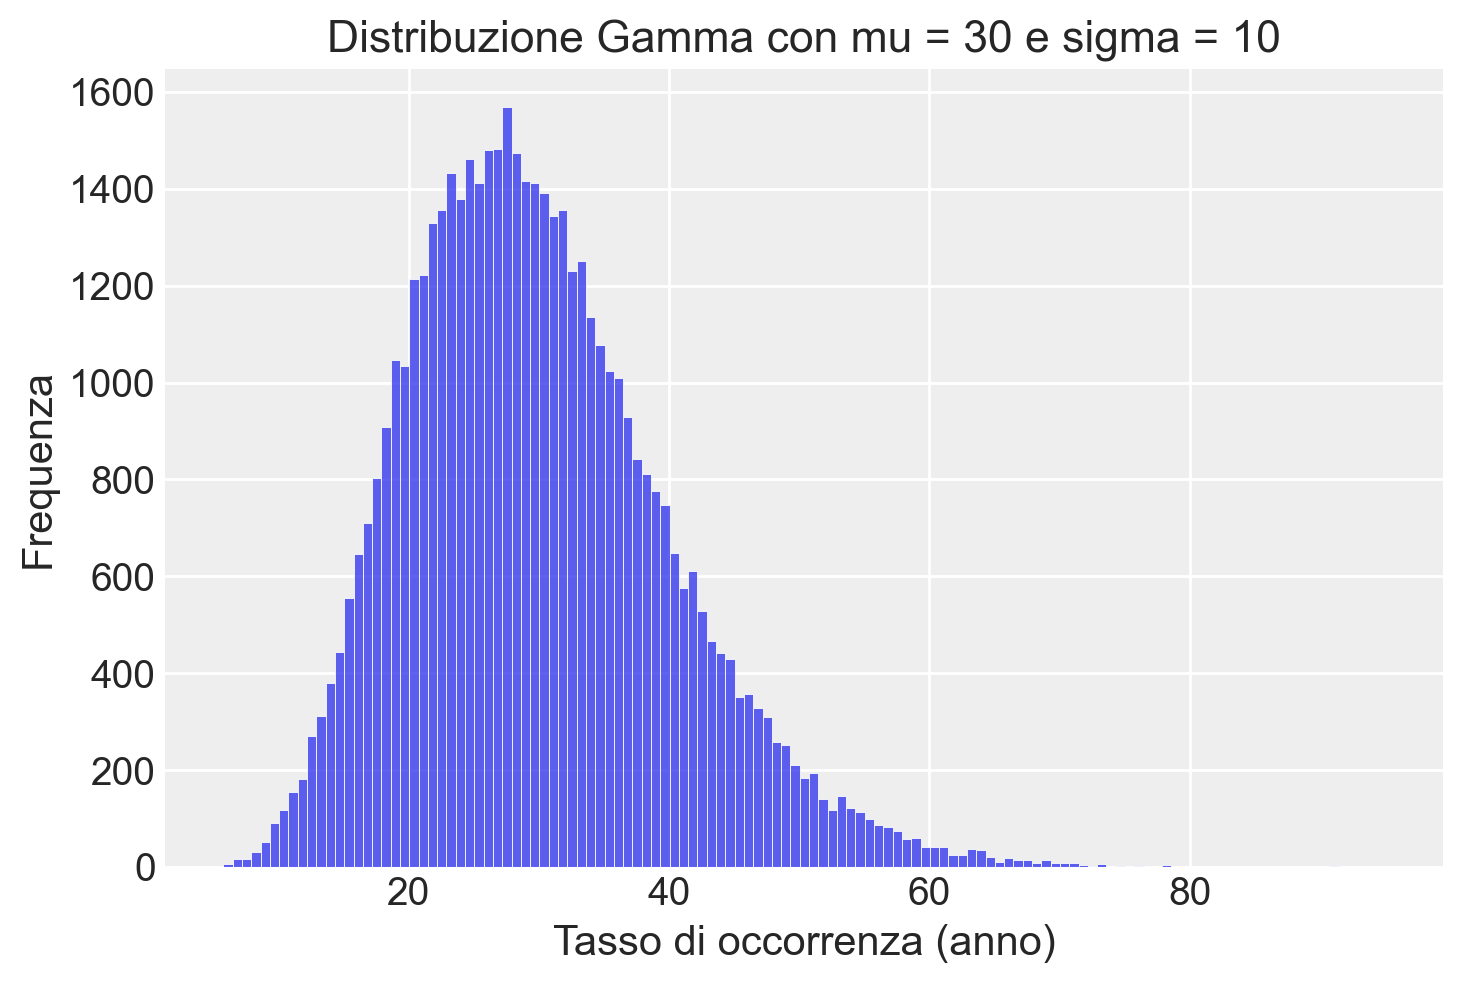

In [24]:
# Parameters for the Gamma distribution
mu = 30
sigma = 10

# Convert mu and sigma to shape (k) and scale (theta) parameters
theta = sigma**2 / mu
k = mu / theta

# Draw samples from the Gamma distribution
x_draws = stats.gamma.rvs(a=k, scale=theta, size=50000, random_state=2)

# Plot the histogram of the drawn samples
sns.histplot(x_draws, kde=False)

# Add labels and title
plt.xlabel("Tasso di occorrenza (anno)")
plt.ylabel("Frequenza")
plt.title("Distribuzione Gamma con mu = 30 e sigma = 10")
plt.show()

Eseguiamo il campionamento per i dati del campione caucasico.

In [25]:
# Gruppo caucasico
stan_data_white = {
    "y": events_by_year_white_race["event_count"],
    "N": 9,
    "mu": 30,
    "sigma": 10,
}

In [26]:
trace_white = model.sample(
    data=stan_data_white,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo la distribuzione a posteriori della frequenze di vittime di razza caucasica.

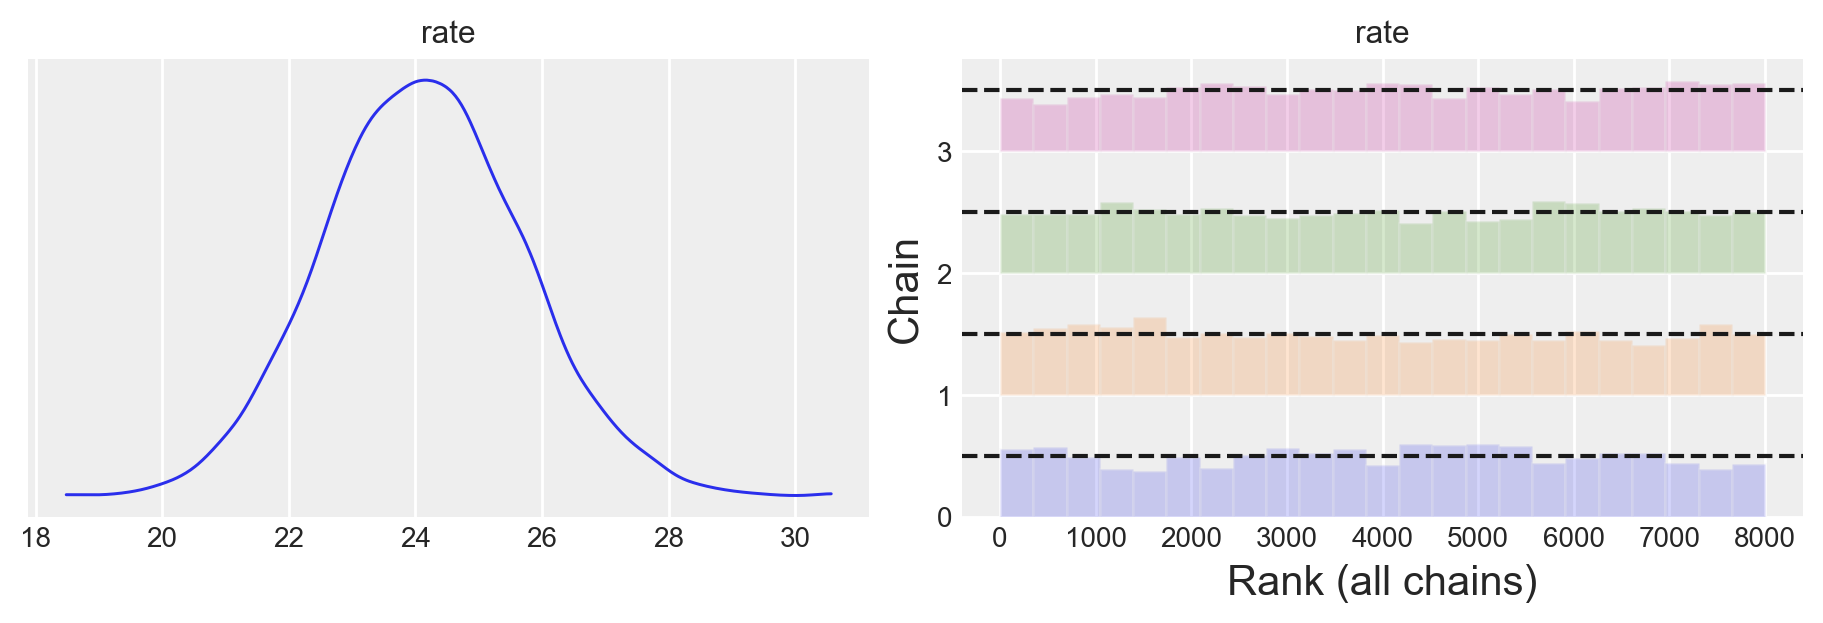

In [27]:
az.plot_trace(trace_white, combined=True, kind="rank_bars", figsize=(9, 3))
plt.show()

In [28]:
az.summary(trace_white)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rate,24.141,1.583,21.246,27.201,0.03,0.021,2864.0,3732.0,1.0


Eseguiamo il campionamento per i dati del campione caucasico.

In [29]:
# Gruppo non caucasico
stan_data_non_white = {
    "y": events_by_year_non_white_race["event_count"],
    "N": 9,
    "mu": 30,
    "sigma": 10,
}

In [30]:
trace_non_white = model.sample(
    data=stan_data_non_white,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo la distribuzione a posteriori della frequenze di vittime di razza noln caucasica.

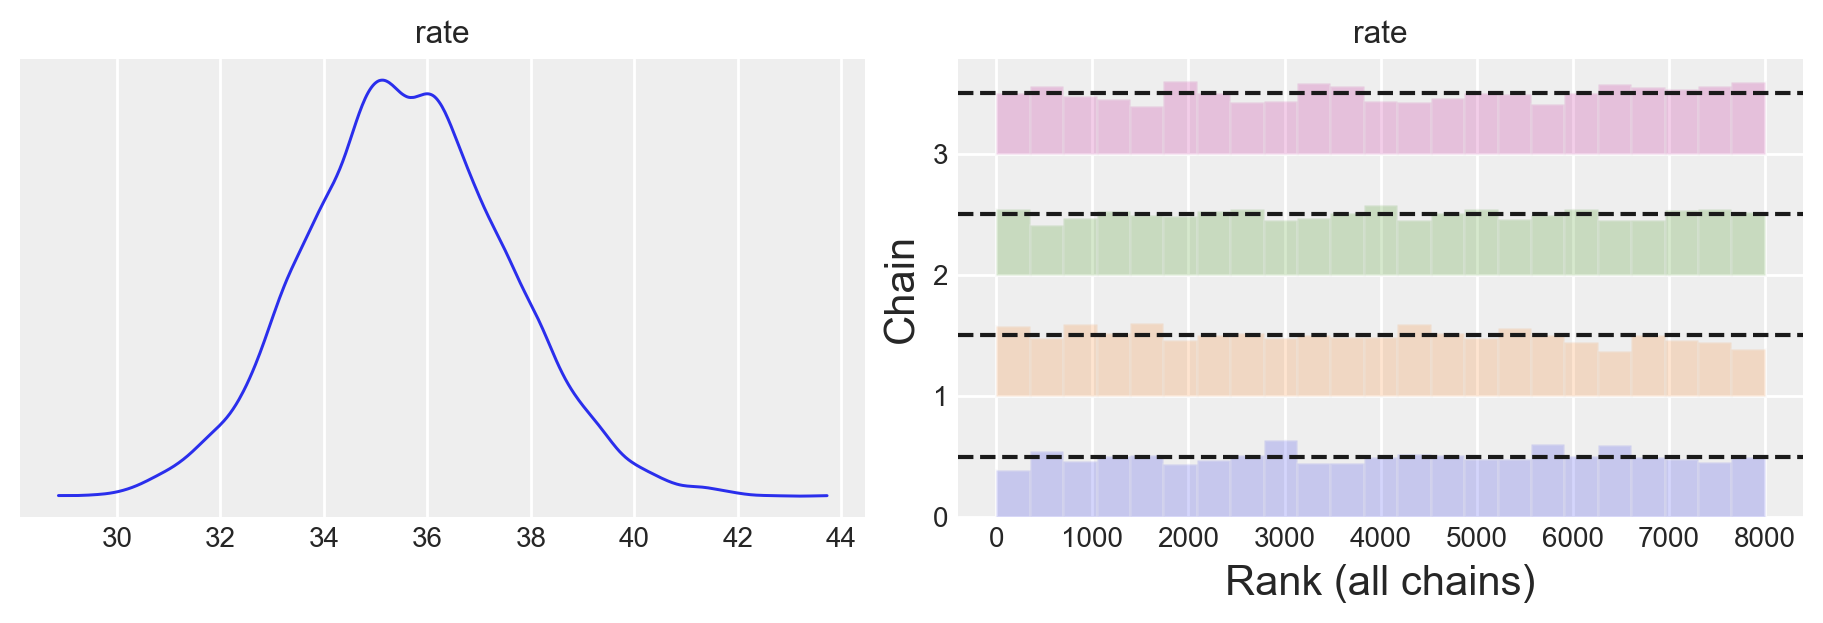

In [31]:
az.plot_trace(trace_non_white, combined=True, kind="rank_bars", figsize=(9, 3))
plt.show()

In [32]:
az.summary(trace_non_white)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rate,35.585,1.937,32.198,39.507,0.035,0.025,2981.0,4217.0,1.0


Il confronto tra i due intervalli di credibilità suggerisce che le frequenze attese del modello di Poisson risultano maggiori nel gruppo non caucasico rispetto al gruppo caucasico. È importante considerare anche che la popolazione caucasica negli Stati Uniti è numericamente superiore rispetto agli individui non caucasici.

## Modello combinato per i due gruppi

In alternativa, possiamo creare un modello Stan unico che valuti direttamente la differenza a posteriori delle frequenze attese dal modello di Poisson per i due gruppi. Per fare questo, possiamo estendere il modello per includere due rate, uno per ogni gruppo, e calcolare la differenza a posteriori delle frequenze attese.

In [33]:
stan_file = os.path.join(project_directory, "stan", "poisson_diff_model.stan")
model = CmdStanModel(stan_file=stan_file)

In [34]:
print(model.code())

data {
  int<lower=0> N; // numero di osservazioni per ogni gruppo
  real<lower=0> mu; // parametro mu per la distribuzione Gamma
  real<lower=0> sigma; // parametro sigma per la distribuzione Gamma
  array[N] int<lower=0> y_white; // dati osservati per il gruppo caucasico
  array[N] int<lower=0> y_non_white; // dati osservati per il gruppo non caucasico
}
parameters {
  real<lower=0> rate_white; // parametro rate per la distribuzione Poisson per il gruppo caucasico
  real<lower=0> rate_non_white; // parametro rate per la distribuzione Poisson per il gruppo non caucasico
}
model {
  // Priori
  rate_white ~ gamma(mu ^ 2 / sigma ^ 2, mu / sigma ^ 2);
  rate_non_white ~ gamma(mu ^ 2 / sigma ^ 2, mu / sigma ^ 2);
  
  // Likelihood
  y_white ~ poisson(rate_white);
  y_non_white ~ poisson(rate_non_white);
}
generated quantities {
  real diff_rate = rate_non_white - rate_white; // differenza tra le frequenze attese
}



Nel blocco `generated quantities` calcoliamo la distribuzione a posteriori della differenza tra i tassi di occorrenza stimati per i gruppi non caucasici e caucasici. Questa differenza permette di quantificare direttamente il confronto tra i tassi di incidenza dei due gruppi.

Generiamo il dizionario appropriato per il modello.

In [35]:
stan_groups_data = {
    "N": 9,
    "mu": 30,
    "sigma": 10,
    "y_white": events_by_year_white_race["event_count"],
    "y_non_white": events_by_year_non_white_race["event_count"],
}
print(stan_groups_data)

{'N': 9, 'mu': 30, 'sigma': 10, 'y_white': 0    31
1    29
2    29
3    26
4    26
5    27
6     7
7    23
8    17
Name: event_count, dtype: int64, 'y_non_white': 0    63
1    35
2    40
3    33
4    28
5    34
6    26
7    28
8    34
Name: event_count, dtype: int64}


Eseguiamo il campionamento.

In [36]:
trace_groups = model.sample(
    data=stan_groups_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo la distribuzione a posteriori del parametro di interesse.

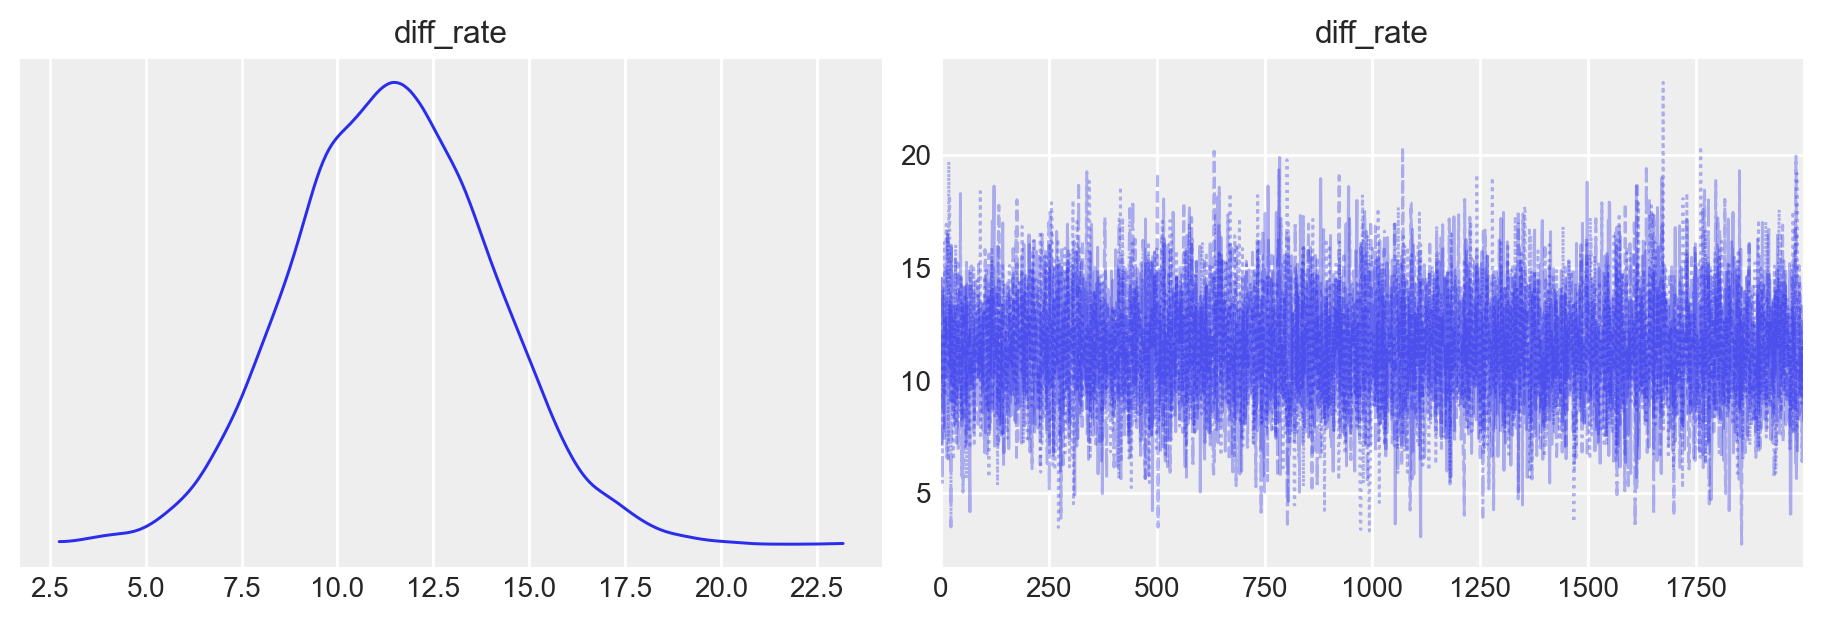

In [37]:
_ = az.plot_trace(trace_groups, combined=True, var_names=["diff_rate"], figsize= (9, 3))

In [38]:
az.summary(trace_groups)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
diff_rate,11.436,2.572,6.636,16.211,0.031,0.022,6783.0,5100.0,1.0
rate_non_white,35.498,1.971,31.864,39.196,0.024,0.017,6787.0,5212.0,1.0
rate_white,24.062,1.608,21.050,27.032,0.020,0.014,6776.0,5147.0,1.0


Sulla base dei risultati ottenuti dal modello di Poisson, possiamo trarre le seguenti conclusioni:

Il tasso stimato di incidenza delle vittime disarmate uccise dalla polizia negli Stati Uniti è più alto per il gruppo non caucasico rispetto al gruppo caucasico. La differenza media stimata tra i due tassi di incidenza è di 11.508, con una deviazione standard di 2.586. Questo significa che, in media, il tasso per il gruppo non caucasico è di circa 11.5 punti superiore rispetto al tasso per il gruppo caucasico.

L'intervallo di credibilità al 94% per questa differenza va da 6.792 a 16.443, indicando che è molto probabile che la vera differenza tra i tassi di incidenza dei due gruppi si trovi all'interno di questo intervallo. Questo intervallo di credibilità non include lo zero, il che fornisce ulteriore evidenza che il tasso di incidenza per il gruppo non caucasico è effettivamente più alto rispetto al gruppo caucasico.

Inoltre, i tassi di incidenza stimati per ciascun gruppo sono i seguenti:

- **Gruppo non caucasico:** tasso medio di 35.577 con un intervallo di credibilità al 94% tra 31.978 e 39.260.
- **Gruppo caucasico:** tasso medio di 24.069 con un intervallo di credibilità al 94% tra 21.098 e 27.285.

Questi risultati indicano chiaramente che il gruppo non caucasico ha un tasso di incidenza più alto di vittime disarmate uccise dalla polizia rispetto al gruppo caucasico. L'intervallo di credibilità per ciascun tasso fornisce una stima robusta e credibile della variabilità di questi tassi.

In sintesi, il modello di Poisson fornisce una forte evidenza che esiste una differenza robusta tra i tassi di incidenza dei due gruppi, con il gruppo non caucasico che presenta un tasso più elevato di vittime disarmate uccise dalla polizia rispetto al gruppo caucasico.

## Esercizi

::: {#exr-poisson-processes-1}

Nella finale olimpica di calcio 2024, la Spagna ha sconfitto la Francia con un punteggio di 5 a 3. Supponiamo di voler calcolare la probabilità di superiorità della Spagna rispetto alla Francia utilizzando un modello coniugato gamma-poisson.

Per fare ciò, consideriamo che il numero di gol segnati da una squadra in una partita segua una distribuzione di Poisson, con un parametro λ che rappresenta il tasso medio di gol per partita. Supponiamo di avere una distribuzione a priori gamma per λ con i parametri $\alpha = 1$ e $\beta = 1$ sia per la Spagna che per la Francia. Questi parametri rappresentano la nostra incertezza iniziale sulla capacità delle squadre di segnare gol.

1. Calcola la distribuzione a posteriori del tasso medio di gol (λ) per entrambe le squadre dopo aver osservato il risultato della partita.
2. Utilizzando queste distribuzioni a posteriori, calcola la probabilità che la Spagna sia superiore alla Francia, definita come la probabilità che $λ_{Spagna} > λ_{Francia}$, ovvero la probabilità che la Spagna abbia un tasso medio di gol superiore rispetto alla Francia (Esercizio ispirato da *The World Cup Problem*, @downey2021think).

:::

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [39]:
%load_ext watermark
%watermark -n -u -v -iv -m 

Last updated: Thu Oct 03 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 24.0.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

scipy     : 1.14.0
logging   : 0.5.1.2
cmdstanpy : 1.2.4
seaborn   : 0.13.2
matplotlib: 3.9.1
numpy     : 1.26.4
arviz     : 0.18.0
pandas    : 2.2.2

